<a href="https://colab.research.google.com/github/soc8/not_yet/blob/master/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
##### Copyright 2020 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
# A fast numpy reference implementation of GHT, as per
# "A Generalization of Otsu's Method and Minimum Error Thresholding"
# Jonathan T. Barron, ECCV, 2020


import numpy as np

csum = lambda z: np.cumsum(z)[:-1]
dsum = lambda z: np.cumsum(z[::-1])[-2::-1]
argmax = lambda x, f: np.mean(x[:-1][f == np.max(f)])  # Use the mean for ties.
clip = lambda z: np.maximum(1e-30, z)

def preliminaries(n, x):
  """Some math that is shared across multiple algorithms."""
  assert np.all(n >= 0)
  x = np.arange(len(n), dtype=n.dtype) if x is None else x
  assert np.all(x[1:] >= x[:-1])
  w0 = clip(csum(n))
  w1 = clip(dsum(n))
  p0 = w0 / (w0 + w1)
  p1 = w1 / (w0 + w1)
  mu0 = csum(n * x) / w0
  mu1 = dsum(n * x) / w1
  d0 = csum(n * x**2) - w0 * mu0**2
  d1 = dsum(n * x**2) - w1 * mu1**2
  return x, w0, w1, p0, p1, mu0, mu1, d0, d1

def GHT(n, x=None, nu=0, tau=0, kappa=0, omega=0.5):
  assert nu >= 0
  assert tau >= 0
  assert kappa >= 0
  assert omega >= 0 and omega <= 1
  x, w0, w1, p0, p1, _, _, d0, d1 = preliminaries(n, x)
  v0 = clip((p0 * nu * tau**2 + d0) / (p0 * nu + w0))
  v1 = clip((p1 * nu * tau**2 + d1) / (p1 * nu + w1))
  f0 = -d0 / v0 - w0 * np.log(v0) + 2 * (w0 + kappa *      omega)  * np.log(w0)
  f1 = -d1 / v1 - w1 * np.log(v1) + 2 * (w1 + kappa * (1 - omega)) * np.log(w1)
  return argmax(x, f0 + f1), f0 + f1

In [4]:
# Implementations of the existing algorithms that are special cases of GHT().

def Otsu(n, x=None):
  """Otsu's method."""
  x, w0, w1, _, _, mu0, mu1, _, _ = preliminaries(n, x)
  o = w0 * w1 * (mu0 - mu1)**2
  return argmax(x, o), o

def Otsu_equivalent(n, x=None):
  """Equivalent to Otsu's method."""
  x, _, _, _, _, _, _, d0, d1 = preliminaries(n, x)
  o = np.sum(n) * np.sum(n * x**2) - np.sum(n * x)**2 - np.sum(n) * (d0 + d1)
  return argmax(x, o), o

def MET(n, x=None):
  """Minimum Error Thresholding."""
  x, w0, w1, _, _, _, _, d0, d1 = preliminaries(n, x)
  ell = (1 + w0 * np.log(clip(d0 / w0)) + w1 * np.log(clip(d1 / w1))
      - 2 * (w0 * np.log(clip(w0))      + w1 * np.log(clip(w1))))
  return argmax(x, -ell), ell  # argmin()

def wprctile(n, x=None, omega=0.5):
  """Weighted percentile, with weighted median as default."""
  assert omega >= 0 and omega <= 1
  x, _, _, p0, p1, _, _, _, _ = preliminaries(n, x)
  h = -omega * np.log(clip(p0)) - (1. - omega) * np.log(clip(p1))
  return argmax(x, -h), h  # argmin()

In [5]:
# An additional equivalent implementation of GHT that uses an explicit for-loop
# over splits of the histogram instead of the cumulative sum approach used by
# the paper. This additional implementation is intended to allow for easier
# comparisons with similar implementations of MET or Otsu's method, and to
# allow existing implementations of MET or Otsu's method to be easily
# generalized into implementations of GHT.

def GHT_forloop(n, x=None, nu=0, tau=0, kappa=0, omega=0.5):
  """An implementation of GHT() written using for loops."""
  assert np.all(n >= 0)
  x = np.arange(len(n), dtype=n.dtype) if x is None else x
  assert np.all(x[1:] >= x[:-1])
  assert nu >= 0
  assert tau >= 0
  assert kappa >= 0
  assert omega >= 0 and omega <= 1

  n_sum = np.sum(n)
  nx_sum = np.sum(n * x)
  nxx_sum = np.sum(n * x**2)

  max_score, n_c, nx_c, nxx_c = -np.inf, 0, 0, 0
  for i in range(len(n) - 1):
    n_c += n[i]
    nx_c += n[i] * x[i]
    nxx_c += n[i] * x[i]**2
    w0 = clip(n_c)
    w1 = clip(n_sum - n_c)
    p0 = w0 / n_sum
    p1 = w1 / n_sum
    d0 = np.maximum(0, nxx_c - nx_c**2 / w0)
    d1 = np.maximum(0, (nxx_sum - nxx_c) - (nx_sum - nx_c)**2 / w1)
    v0 = clip((p0 * nu * tau**2 + d0) / (p0 * nu + w0))
    v1 = clip((p1 * nu * tau**2 + d1) / (p1 * nu + w1))
    f0 = -d0 / v0 - w0 * np.log(v0) + 2 * (w0 + kappa *      omega)  * np.log(w0)
    f1 = -d1 / v1 - w1 * np.log(v1) + 2 * (w1 + kappa * (1 - omega)) * np.log(w1)
    score = f0 + f1

    # Argmax where the mean() is used for ties.
    if score > max_score:
      max_score, t_numer, t_denom = score, 0, 0
    if score == max_score:
      t_numer += x[i]
      t_denom += 1
  return t_numer / t_denom

In [6]:
# An implementation of GHT in terms of the actual underlying ECLL maximization
# that reduces to GHT() above. This implementation is highly inefficient, but
# can be used to verify the correctness of GHT in terms of its Bayesian
# motivation, and may be useful in deriving further probabilistic extensions.

from tensorflow_probability import distributions as tfd

def sichi2_var(n, resid, nu, tau):
  """Posterior estimate of variance for a scaled inverse chi-squared."""
  return (nu * tau**2 + np.sum(n * resid**2)) / (nu + np.sum(n))

def GHT_prob(n, x=None, nu=0, tau=0, kappa=0, omega=0.5):
  """An implementation of GHT() using probability distributions."""
  assert np.all(n >= 0)
  x = np.arange(len(n), dtype=n.dtype) if x is None else x
  assert np.all(x[1:] >= x[:-1])
  assert nu >= 0
  assert tau >= 0
  assert kappa >= 0
  assert omega >= 0 and omega <= 1

  n_sum = np.sum(n)
  lls = np.zeros(len(n) - 1)
  for i in range(len(lls)):
    n0, n1 = n[:(i+1)], n[(i+1):]
    x0, x1 = x[:(i+1)], x[(i+1):]
    w0 = clip(np.sum(n0))
    w1 = clip(np.sum(n1))
    p0 = clip(w0 / n_sum)
    p1 = clip(w1 / n_sum)
    mu0 = np.sum(n0 * x0) / w0
    mu1 = np.sum(n1 * x1) / w1
    var0 = sichi2_var(n0, x0 - mu0, p0 * nu, tau)
    var1 = sichi2_var(n1, x1 - mu1, p1 * nu, tau)
    lls[i] = ((np.sum(n0 * (np.log(p0) + tfd.Normal(mu0, np.sqrt(var0)).log_prob(x0)))
             + np.sum(n1 * (np.log(p1) + tfd.Normal(mu1, np.sqrt(var1)).log_prob(x1))))
             + tfd.Beta(kappa * omega + 1, kappa * (1 - omega) + 1).log_prob(np.minimum(p0, 1-1e-15)))
  return np.mean(x[:-1][lls == np.max(lls)]), lls

In [14]:
# Unit tests for verifying that the math in the paper is right.

import numpy as np
import scipy.special
import tensorflow as tf
from tensorflow_probability import distributions as tfd


def run_tests():
  def fit_affine(x, y):
    aff = np.linalg.lstsq(np.stack([x, np.ones_like(x)]).T, y,rcond=None)[0]
    y_ = x * aff[0] + aff[1]
    resid = y - y_
    return aff, resid


  class GhtTest(tf.test.TestCase):

    def affine_equivalence(self, x, y, atol=1e-4, rtol=1e-4):

      def center(z):
        z = z - np.mean(z)
        z = z / np.maximum(1e-15, np.max(np.abs(z)))
        return z

      x = center(x)
      y = center(y)
      aff = fit_affine(x, y)[0]
      self.assertGreater(aff[0], 0)
      y_ = x * aff[0] + aff[1]
      x_ = (y - aff[1]) / aff[0]
      x_max = np.abs(np.maximum(np.max(x), np.max(x_)))
      y_max = np.abs(np.maximum(np.max(y), np.max(y_)))
      self.assertAllClose(x / x_max, x_ / x_max, atol=atol, rtol=rtol)
      self.assertAllClose(y / y_max, y_ / y_max, atol=atol, rtol=rtol)

    def setUp(self):
      super(GhtTest, self).setUp()
      np.random.seed(0)
      self.data = []
      for _ in range(1000):
        n = np.maximum(0., np.random.uniform(low=-1., high=5., size=100))
        dx = np.random.uniform(low=0.1, high=1., size=len(n))
        x = np.cumsum(dx)
        x = x - np.random.uniform() * x[-1]
        self.data.append((n, x))

    def testOtsuImplementationsMatch(self):
      for (n, x) in self.data:
        t, scores = Otsu(n, x)
        t_, scores_ = Otsu_equivalent(n, x)
        self.assertAllClose(t, t_)
        self.assertAllClose(scores, scores_)

    def testMetLlMatchesScore(self):
      """Sanity check an equation."""
      for (n, x) in self.data:
        _, score = GHT(n, x)
        _, ell = MET(n, x)
        self.assertAllClose(
            score[5:-5], 1 - np.sum(n) - ell[5:-5], atol=1e-2, rtol=1e-2)

    def testGhtApproachesOtsu(self):
      """Ght with nu >> 0 and tau near 0 is equivalent to otsu."""
      nu = 1e30
      for (n, x) in self.data:
        x, w0, w1, _, _, _, _, d0, d1 = preliminaries(n, x)

        tau = 7.
        _, thresh_scores = GHT(n, x, nu=nu, tau=tau)
        ref_scores = (-(d0 + d1) / tau**2 + 2 * w0 * np.log(w0 / tau) +
                      2 * w1 * np.log(w1 / tau))
        self.assertAllClose(thresh_scores, ref_scores)

        tau = 1e-6
        t, thresh_scores = GHT(n, x, nu=nu, tau=tau)
        ref_scores = -(d0 + d1) / tau**2
        self.assertAllClose(thresh_scores, ref_scores)

        t_, _ = Otsu(n, x)
        self.assertAllClose(t, t_)

    def testGhtApproachesEntropy(self):
      """Ght with nu >> 0 and tau >> 0 is equivalent to stupid entropy."""
      nu = 1e30
      tau = 1e15
      for (n, x) in self.data:
        _, scores = GHT(n, x, nu=nu, tau=tau)

        x, _, _, p0, p1, _, _, _, _ = preliminaries(n, x)

        n_sum = np.sum(n)
        neg_h = p0 * np.log(p0) + p1 * np.log(p1)
        self.assertAllClose(neg_h,
                            scores / (2 * n_sum) - np.log(n_sum) + np.log(tau))

    def testGhtApproachesMet(self):
      """Ght with default params is ~MET."""
      err_count = 0
      for (n, x) in self.data:
        t, eclls = GHT(n, x)
        t_, eclls_ = MET(n, x)
        self.affine_equivalence(-eclls[5:-5], eclls_[5:-5], atol=1e-2, rtol=1e-2)
        if t != t_:
          err_count += 1
      print('err_count = {}/{}'.format(err_count, len(self.data)))
      self.assertLess(err_count, (len(self.data) // 10))

    def testGhtDefaultWorks(self):
      """Ght with no x argument works."""
      for (n, _) in self.data:
        x = np.arange(len(n))
        t, scores = GHT(n, x)
        t_, scores_ = GHT(n)
        self.assertAllClose(t, t_)
        self.affine_equivalence(scores, scores_)

    def testGhtApproachesPercentile(self):
      # Cranking up the regularizer reproduces a percentile.
      for (n, x) in self.data:
        omega = np.random.uniform(0.01, 0.99)
        t, _ = GHT(n, x, kappa=1e30, omega=omega)
        t_, _ = wprctile(n, x, omega)
        self.assertAllClose(t, t_, atol=1e-3, rtol=1e-3)

    def testOtsuIsScaleInvariant(self):
      for (n, x) in self.data:
        n_mult = np.exp(np.random.normal())
        t, _ = Otsu(n, x)
        t_, _ = Otsu(n_mult * n, x)
        self.assertAllClose(t, t_)

    def testGhtIsScaleInvariantWrtN(self):
      for (n, x) in self.data:
        nu = 2.**np.random.normal(scale=6)
        tau = 2.**np.random.normal(scale=3)
        kappa = 2.**np.random.normal(scale=6)
        omega = np.random.uniform(low=0.001, high=0.999)
        mult = np.exp(np.random.normal())
        t, _ = GHT(n, x, nu, tau, kappa, omega)
        t_, _ = GHT(mult * n, x, mult * nu, tau, mult * kappa, omega)
        self.assertAllClose(t, t_)

    def testGhtWithLargeKappaMatchesApproximation(self):
      for (n, x) in self.data:
        kappa = 1e30
        omega = np.random.uniform(low=0.01, high=0.99)
        t, scores = GHT(n, x, 0, 0, kappa, omega)
        _, _, _, p0, p1, _, _, _, _ = preliminaries(n, x)
        n_sum = np.sum(n)
        scores_ = 2 * (
            np.log(n_sum) * (n_sum + kappa) + kappa * (omega * np.log(p0) +
                                                      (1 - omega) * np.log(p1)))
        t_ = argmax(x, scores_)
        self.assertAllClose(t, t_)
        self.assertAllClose(scores / kappa, scores_ / kappa)

    def testGhtWithLargeKappaMatchesBetaDistribution(self):
      for (n, x) in self.data:
        kappa = 1e30
        omega = np.random.uniform(low=0.01, high=0.99)
        _, scores = GHT(n, x, 0, 0, kappa, omega)
        _, _, _, p0, _, _, _, _, _ = preliminaries(n, x)
        n_sum = np.sum(n)
        alpha = omega * kappa + 1
        beta = (1 - omega) * kappa + 1
        scores_ = 2 * (
            np.log(n_sum) *
            (n_sum + kappa) + tfd.Beta(alpha, beta).log_prob(p0) +
            scipy.special.betaln(alpha, beta))
        mask = np.isfinite(scores_)
        assert np.mean(mask) > 0.9
        self.assertAllClose(
            scores[mask] / kappa, scores_[mask] / kappa, atol=1e-3, rtol=1e-3)

    def testMoGIsScaleInvariant(self):
      err_count = 0
      for (n, x) in self.data:
        n_mult = np.exp(np.random.normal())
        t, _ = MET(n, x)
        t_, _ = MET(n_mult * n, x)
        if t != t_:
          err_count += 1
      # This test is flaky because of numerical weirdness when variances are low.
      print('err_count = {}/{}'.format(err_count, len(self.data)))
      self.assertLess(err_count, (len(self.data) // 5))

    def testPercentileIsScaleInvariant(self):
      for (n, x) in self.data:
        omega = np.random.uniform(low=0.001, high=0.999)
        n_mult = np.exp(np.random.normal())
        t, _ = wprctile(n, x, omega)
        t_, _ = wprctile(n_mult * n, x, omega)
        self.assertAllClose(t, t_)

    def testDecsumCanBeImplementedInASweep(self):
      for (n, _) in self.data:
        n_cum = csum(n)
        n_dec = dsum(n)
        n_dec_ = np.sum(n) - n_cum
        self.assertAllClose(n_dec, n_dec_)

    def testGhtIsAffineInvariantWrtX(self):
      for (n, x) in self.data:
        nu = 2.**np.random.normal(scale=6)
        tau = 2.**np.random.normal(scale=3)
        kappa = 2.**np.random.normal(scale=6)
        omega = np.random.uniform(low=0.001, high=0.999)
        shift = np.random.normal()
        t, scores = GHT(n, x, nu, tau, kappa, omega)

        mult = np.exp(np.random.normal())
        shift = np.random.normal()

        f = lambda z: mult * z + shift
        t_, scores_ = GHT(n, f(x), nu, mult * tau, kappa, omega)

        self.assertAllClose(f(t), t_)

        # `shift` has no effect on scores, `mult` introduces a global shift.
        shift = np.mean(scores_ - scores)
        self.assertAllClose(scores + shift, scores_)

    def testGhtMatchesGhtForLoop(self):
      err_count = 0
      for (n, x) in self.data:
        nu = 2.**np.random.normal(scale=6)
        tau = 2.**np.random.normal(scale=3)
        kappa = 2.**np.random.normal(scale=6)
        omega = np.random.uniform(low=0.001, high=0.999)
        t = GHT(n, x, nu, tau, kappa, omega)[0]
        t_ = GHT_forloop(n, x, nu, tau, kappa, omega)
        if t != t_:
          err_count += 1
      print('err_count = {}/{}'.format(err_count, len(self.data)))
      self.assertLess(err_count, (len(self.data) // 500))

    def testGhtMatchesGhtProb(self):
      # Subsampling the data, because this test is slow.
      self.data = self.data[0:30]
      err_count = 0
      for (n, x) in self.data:
        nu = 2.**np.random.normal(scale=6)
        tau = 2.**np.random.normal(scale=3)
        kappa = np.float64(2.**np.random.normal(scale=6))
        omega = np.float64(np.random.uniform(low=0.001, high=0.999))
        t, scores = GHT(n, x, nu, tau, kappa, omega)
        t_, lls = GHT_prob(n, x, nu, tau, kappa, omega)
        if t != t_:
          err_count += 1
        # There's some flaky floating point math at the edges.
        self.affine_equivalence(scores[5:-5], lls[5:-5])
      print('err_count = {}/{}'.format(err_count, len(self.data)))
      self.assertLess(err_count, (len(self.data) // 3))

  # There is almost certainly a better way to do this...
  ght_test = GhtTest()
  ght_test.setUp()
  ght_test.testOtsuImplementationsMatch()
  ght_test.testMetLlMatchesScore()
  ght_test.testGhtApproachesOtsu()
  ght_test.testGhtApproachesEntropy()
  ght_test.testGhtApproachesMet()
  ght_test.testGhtDefaultWorks()
  ght_test.testGhtApproachesPercentile()
  ght_test.testOtsuIsScaleInvariant()
  ght_test.testGhtIsScaleInvariantWrtN()
  ght_test.testGhtWithLargeKappaMatchesApproximation()
  ght_test.testGhtWithLargeKappaMatchesBetaDistribution()
  ght_test.testMoGIsScaleInvariant()
  ght_test.testPercentileIsScaleInvariant()
  ght_test.testDecsumCanBeImplementedInASweep()
  ght_test.testGhtIsAffineInvariantWrtX()
  ght_test.testGhtMatchesGhtForLoop()
  ght_test.testGhtMatchesGhtProb()

run_tests()

err_count = 55/1000
err_count = 53/1000
err_count = 0/1000
err_count = 4/30


In [8]:
# Code for reproducing Table 1 in the paper.

import os
if not os.path.exists('./HDIBCO2016/'):
  !wget https://github.com/jonbarron/hist_thresh/archive/master.tar.gz
  !tar -xzf master.tar.gz
  FOLDER = './hist_thresh-master/HDIBCO2016/'
else:
  FOLDER = './HDIBCO2016/'

import PIL
import sklearn.metrics

def process(image, gt):
  image = np.amax(image, 2)
  hist_n, hist_edge = np.histogram(image, np.arange(-0.5, 256))
  hist_x = (hist_edge[1:] + hist_edge[:-1]) / 2.
  return (image, hist_x, hist_n), gt > 0


def compute_psnr(x, y, max_val):
  mse = np.mean((np.float32(x) - np.float32(y))**2)
  return 10 * np.log10(max_val**2 / mse)


def compute_drd(gt_flipped, pred_flipped, n=2, b=8):
  pred = ~pred_flipped
  gt = ~gt_flipped

  m = 2 * n + 1

  ns = np.arange(-n, n + 1)
  ij = np.stack(np.meshgrid(ns, ns, indexing='ij'), -1)
  weight = 1. / np.maximum(1, np.sqrt(np.sum(ij**2, -1)))
  weight[n, n] = 0
  weight /= np.sum(weight)

  import tensorflow as tf  # Because numpy doesn't have im2col

  gt_pad = np.pad(np.float32(gt), [(n,n), (n,n)], 'constant', constant_values=np.nan)
  gt_blocks = tf.image.extract_patches(gt_pad[None,:,:,None],
                [1, m, m, 1], strides=[1, 1, 1, 1], rates=[1, 1, 1, 1], padding='VALID')[0].numpy()
  diff = np.nan_to_num((pred[..., None] -  gt_blocks) * np.reshape(weight,  [1, 1, -1]) * (gt != pred)[...,None], 0)
  drdk = np.sum(np.abs(np.reshape(diff, [-1])))

  pad = np.int32(np.ceil(np.array(gt.shape) / b) * b) - np.array(gt.shape)
  gt_pad = np.pad(gt, [(0, pad[0]), (0, pad[1])], 'constant')
  gt_blocks = tf.image.extract_patches(np.int32(gt_pad)[None,:,:,None],
                [1, b, b, 1], strides=[1, b, b, 1], rates=[1, 1, 1, 1], padding='VALID')[0].numpy()
  nubn = np.sum(np.any(gt_blocks[..., 0:1] != gt_blocks, -1))

  drd = drdk / nubn
  return drd


def eval_dataset(data, eval_fun):
  metrics = []
  levels = []
  for (image, hist_x, hist_n), gt in data:
    t = eval_fun(hist_n, hist_x)
    pred = image > t
    metrics.append((
        100. * sklearn.metrics.f1_score(
            np.reshape(~gt, [-1]), np.reshape(~pred, [-1])),
        compute_psnr(gt, pred, 1.),
        compute_drd(gt, pred),
    ))
    levels.append(t)
  return np.array(metrics), np.array(levels)


def stat_fun(z):
  return list(np.reshape(np.stack([np.mean(z, 0), np.std(z, 0)], 1), [-1]))


data = []
for i in range(10):
  image = np.array(PIL.Image.open(FOLDER + 'images/' + str(i) + '.png'))
  gt = np.array(PIL.Image.open(FOLDER + 'gt/' + str(i) + '.png'))
  data.append(process(image, gt))

oracle_levels = [104, 155, 123, 151, 127, 145, 202, 179, 177, 129]
oracle_scores = []
for datum, level in zip(data, oracle_levels):
  oracle_scores.append(eval_dataset([datum], lambda x, n: level)[0])
oracle_scores = np.concatenate(oracle_scores, 0)

# Taken from \cite{dibco2016}
raw_table = [
  ['Kligler \cite{Kligler2017,Katz2007,Howe2013}', 87.61, 6.99, 18.11, 4.27, 5.21, 5.28],
  ['Hassa{\\"i}ne \etal - 3 \cite{Hassane2011,Hassane2012,dibco2016}', 88.72, 4.68, 18.45, 3.41, 3.86, 1.57],
  ['Hassa{\\"i}ne \etal - 2 \cite{Hassane2012,dibco2016}', 88.47, 4.45, 18.29, 3.35, 3.93, 1.37],
  ['Roe \& de Mello \cite{dibco2016}', 87.97, 5.17, 18.00, 3.68, 4.49, 2.65],
  ['Hassa{\\"i}ne \etal- 1 \cite{Hassane2011,dibco2016}', 88.22, 4.80, 18.22, 3.41, 4.01, 1.49 ],
  ['Nafchi \etal - 2 \cite{dibco2016,Nafchi}', 88.11, 4.63, 18.00, 3.41, 4.38, 1.65],
  ['Nafchi \etal - 1 \cite{dibco2016,Nafchi}', 87.60, 4.85, 17.86, 3.51, 4.51, 1.62],
  ['Tensmeyer \& Martinez \cite{tensmeyer2017,Wolf2002TextLE,FCN}', 85.57, 6.75, 17.50, 3.43, 5.00, 2.60],
  ['de Almeida \& de Mello \cite{dibco2016}', 86.24, 5.79, 17.52, 3.42, 5.25, 2.88],
  ['Khan \& Mollah \cite{dibco2016}', 84.32, 6.81, 16.59, 2.99, 6.94, 3.33],
  ['Raza \cite{dibco2016}', 76.28, 9.71, 14.21, 2.21, 15.14, 9.42],
  ['Kefali \etal \cite{Sari2014TextEF,dibco2016}', 76.10, 13.81, 15.35, 3.19, 9.16, 4.87],
  ['Otsu\'s Method \cite{dibco2016,Otsu}', 86.61, 7.26, 17.80, 4.51, 5.56, 4.44],
  ['Sauvola \cite{dibco2016,Sauvola2000AdaptiveDI}', 82.52, 9.65, 16.42, 2.87, 7.49, 3.97]]

experiments = [
  ('Otsu\'s Method (Our Impl.) \\cite{Otsu}', Otsu, None),
  ('{\\bf GHT (Otsu Case)}', GHT, (1e60, 1e-15, 0, 0)),
  ('{\\bf GHT (MET Case)}', GHT, (0, 0, 0, 0)),
  ('{\\bf GHT (wprctile Case)}', GHT, (0, 0, 1e60, 2**-3.75)),
  ('{\\bf GHT (No wprctile)}', GHT, (2.**50.5, 2**0.125, 0, 0)),
  ('{\\bf GHT}', GHT, (2.**29.5, 2**3.125, 2.**22.25, 2.**-3.25)),
]

raw_table = [(name + ' &&&& ', a, b, c, d, e, f) for name, a, b, c, d, e, f in raw_table]

experiment_results = []
for name, algo, params in experiments:
  if params is None:
    name += ' &&&&'
    eval_fun = lambda x, n: algo(x, n)[0]
  else:
    for p in params:
      if p == 0:
        name += ' & - '
      else:
        if p >= 1e25 or p <= 1e-14:
          name += ' & $10^{{{:g}}}$ '.format(np.log10(p))
        else:
          name += ' & $2^{{{:g}}}$ '.format(np.log2(p))
    eval_fun = lambda x, n: algo(x, n, *params)[0]
  metrics, levels = eval_dataset(data, eval_fun)
  raw_table += [[name] + stat_fun(metrics)]
  experiment_results.append(levels)

sorted1 = np.unique([z[1] for z in raw_table])[::-1]
sorted2 = np.unique([z[3] for z in raw_table])[::-1]
sorted3 = np.unique([z[5] for z in raw_table])
for i in np.argsort([z[1] for z in raw_table]):
  row = raw_table[i]
  if sorted3[0] == row[5]:
    tag3 = '\\cellcolor{red}'
  elif sorted3[1] == row[5]:
    tag3 = '\\cellcolor{orange}'
  elif sorted3[2] == row[5]:
    tag3 = '\\cellcolor{yellow}'
  else:
    tag3 = ''
  if sorted2[0] == row[3]:
    tag2 = '\\cellcolor{red}'
  elif sorted2[1] == row[3]:
    tag2 = '\\cellcolor{orange}'
  elif sorted2[2] == row[3]:
    tag2 = '\\cellcolor{yellow}'
  else:
    tag2 = ''
  if sorted1[0] == row[1]:
    tag1 = '\\cellcolor{red}'
  elif sorted1[1] == row[1]:
    tag1 = '\\cellcolor{orange}'
  elif sorted1[2] == row[1]:
    tag1 = '\\cellcolor{yellow}'
  else:
    tag1 = ''
  print(
      '{:90} & {:18} ${:0.2f} \\pm {:0.2f}$ & {:18} ${:0.2f} \\pm {:0.2f}$ & {:18} ${:0.2f} \\pm {:0.2f}$ \\\\'
      .format(row[0], tag1, row[1], row[2], tag2, row[3], row[4], tag3, row[5], row[6]))

print('\\hline')
print('{:90} & ${:0.2f} \\pm {:0.2f}$ & ${:0.2f} \\pm {:0.2f}$ & ${:0.2f} \\pm {:0.2f}$'.format(
    *tuple(['\\rowcolor{lightgray} Oracle Global Threshold &&&& '] +
            list(stat_fun(oracle_scores)))))


--2024-10-22 16:34:25--  https://github.com/jonbarron/hist_thresh/archive/master.tar.gz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/jonbarron/hist_thresh/tar.gz/refs/heads/master [following]
--2024-10-22 16:34:25--  https://codeload.github.com/jonbarron/hist_thresh/tar.gz/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘master.tar.gz’

master.tar.gz           [  <=>               ]   8.67M  26.7MB/s    in 0.3s    

2024-10-22 16:34:25 (26.7 MB/s) - ‘master.tar.gz’ saved [9091452]

{\bf GHT (MET Case)} & -  & -  & -  & -                                                    &                    $60.40 \pm 20

In [10]:
# Let's make some figures.

! sudo apt-get install texlive-latex-recommended texlive-latex-extra dvipng cm-super

import matplotlib.pyplot as plt
from matplotlib import rc

plt.rc('font', family='serif')
rc('text', usetex=True)
# plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

colors = [(0.8680, 0.4061, 0.2064), (0.9236, 0.6709, 0.0588),
          (0.4791, 0.6820, 0.2079), (0.0643, 0.6587, 0.9103),
          (0.1465, 0.5280, 0.7790), (0.5217, 0.2286, 0.5803),
          (0.7158, 0.2820, 0.3646)]

SAVE_FIGURES = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


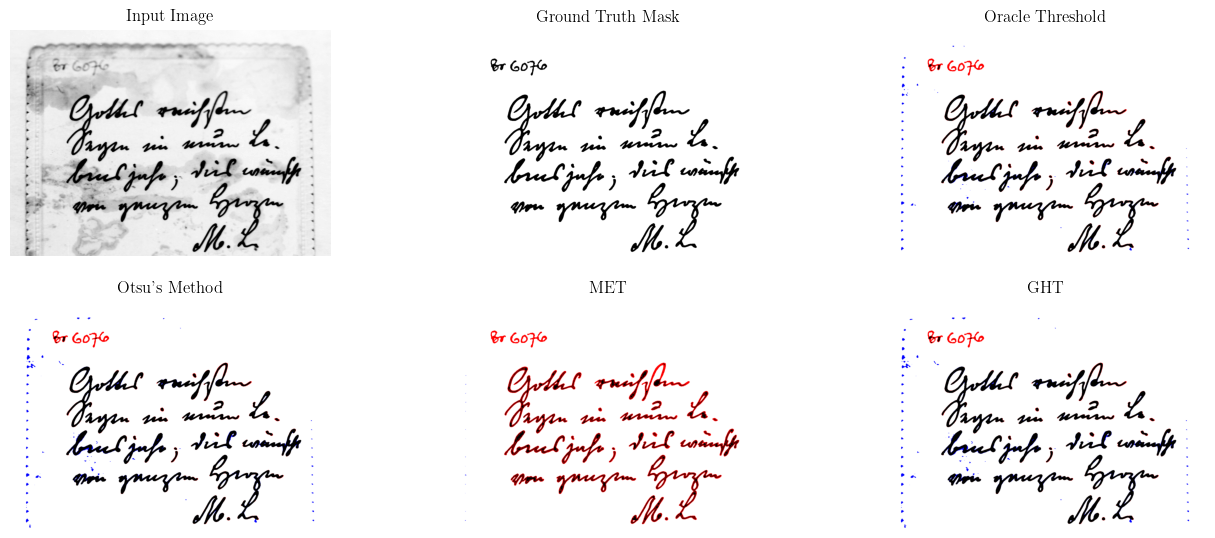

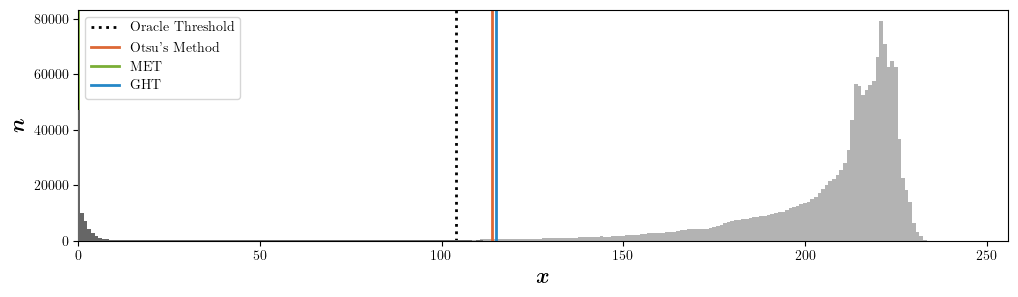

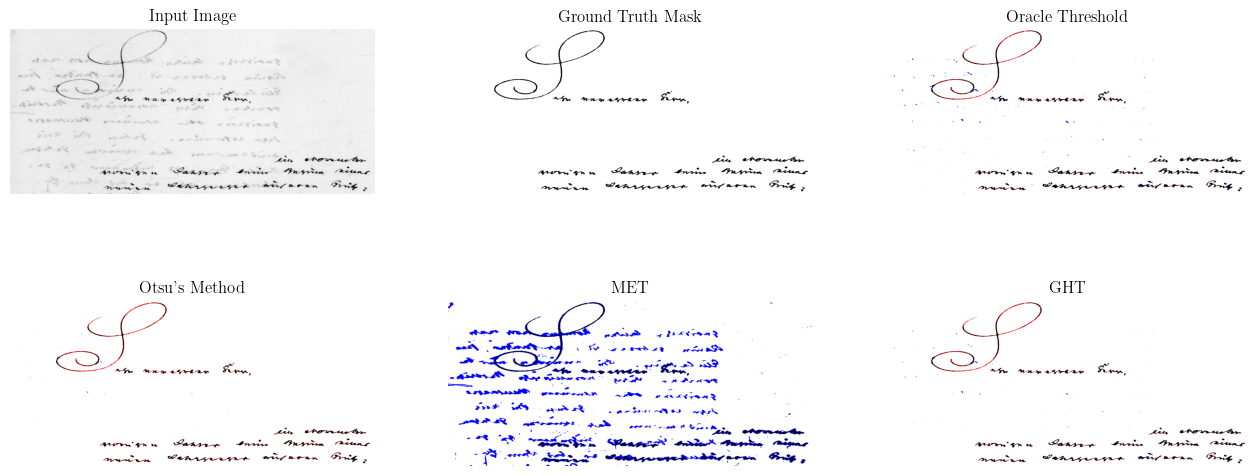

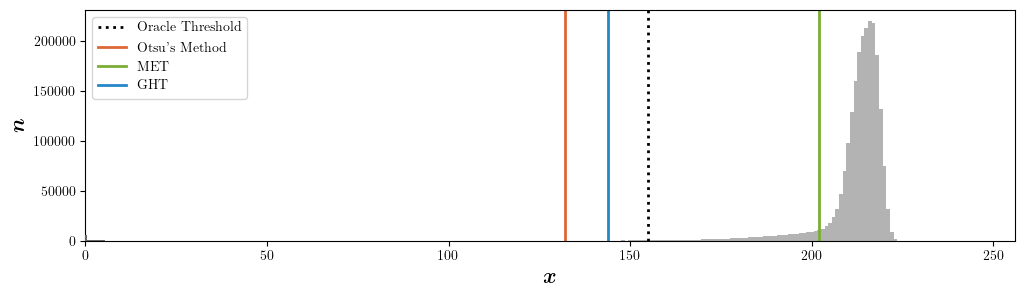

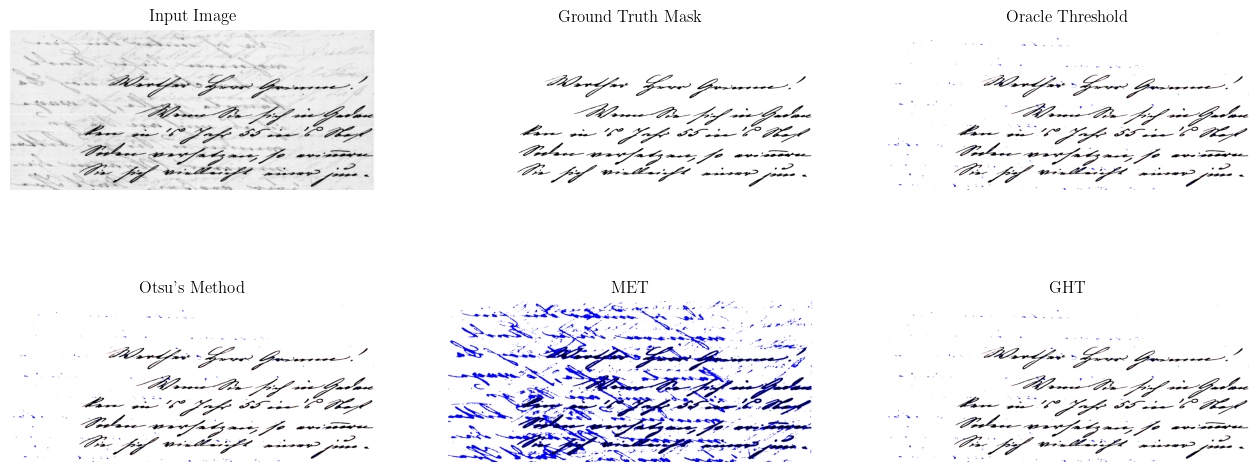

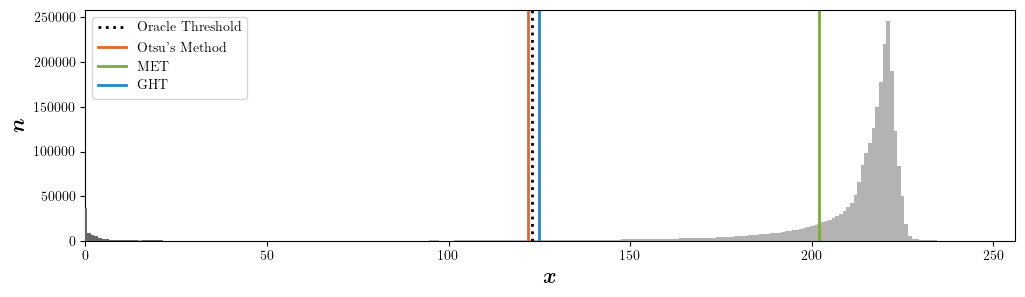

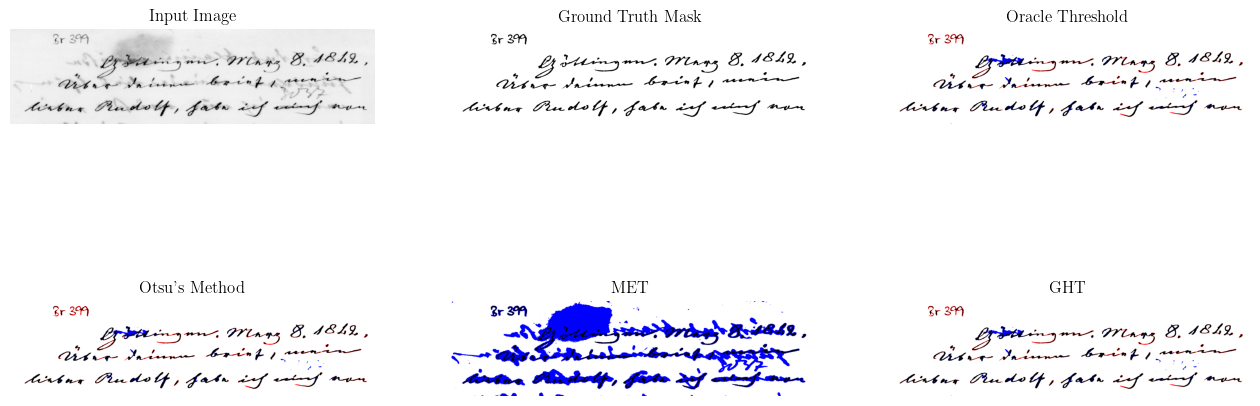

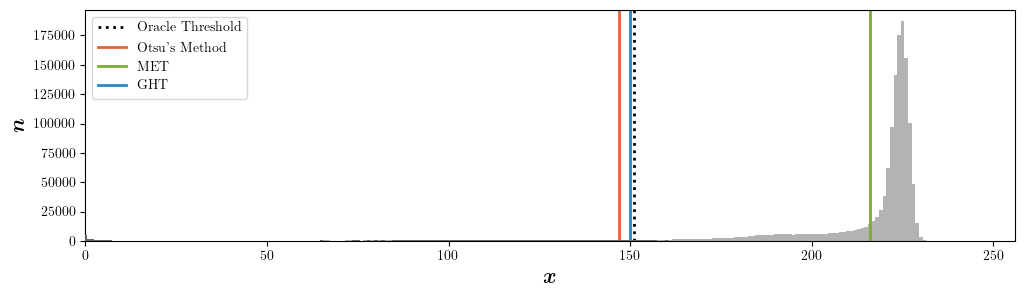

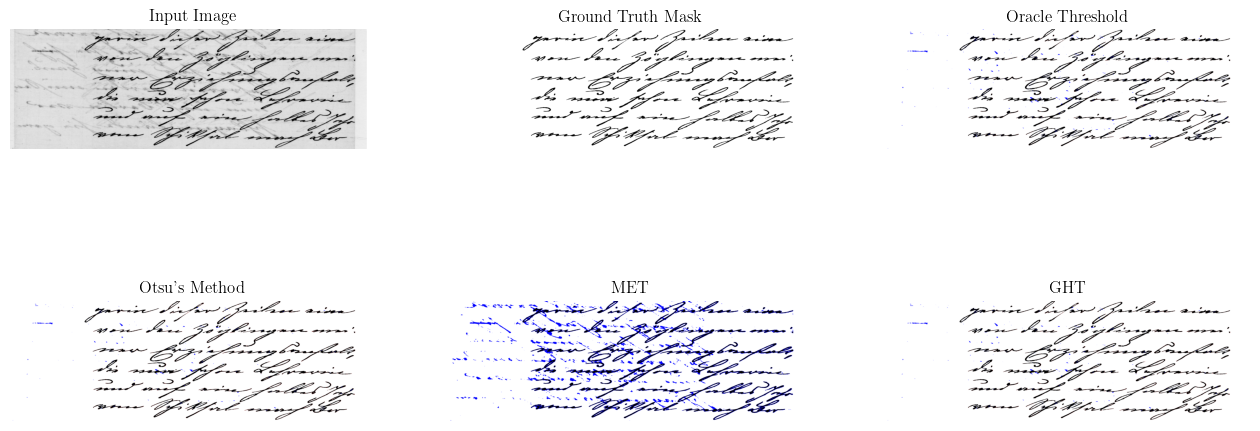

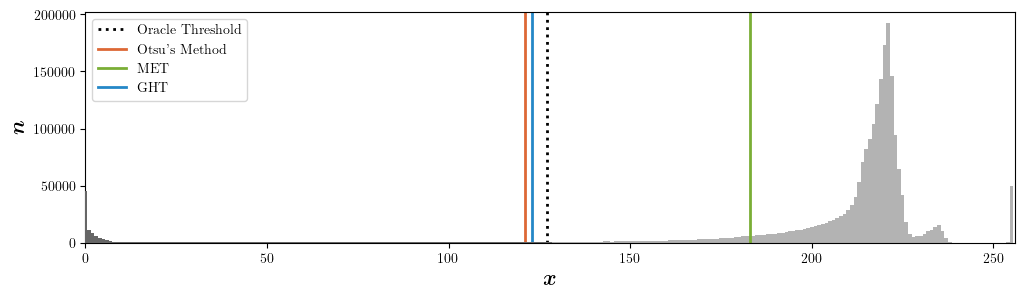

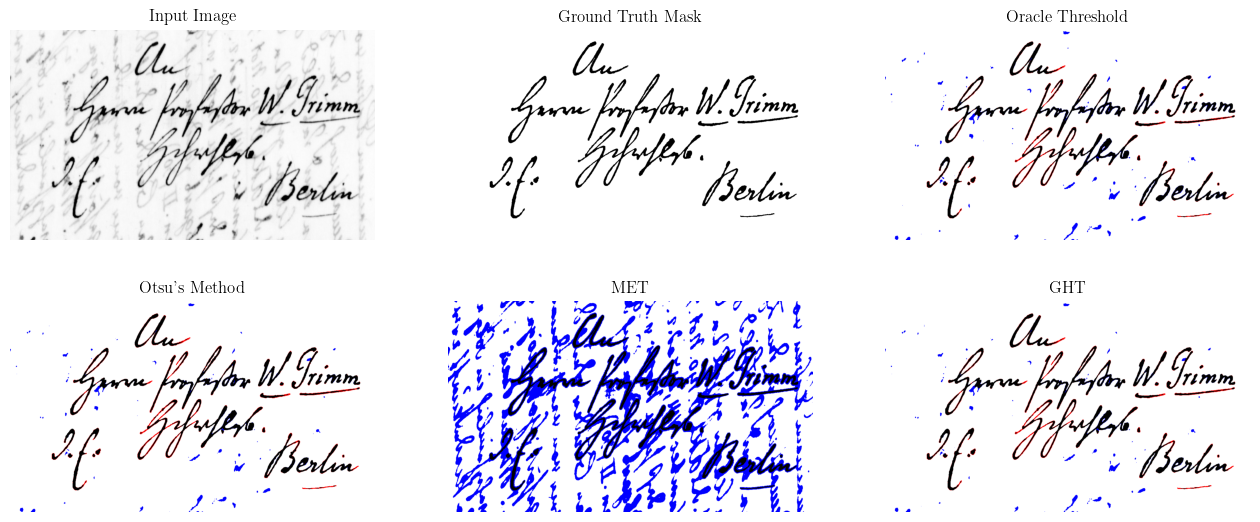

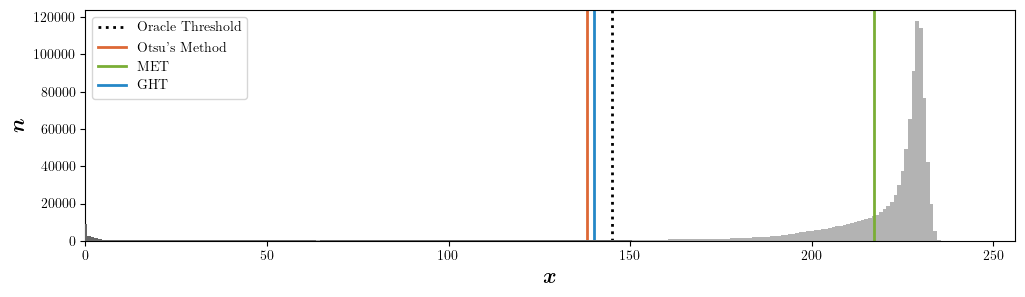

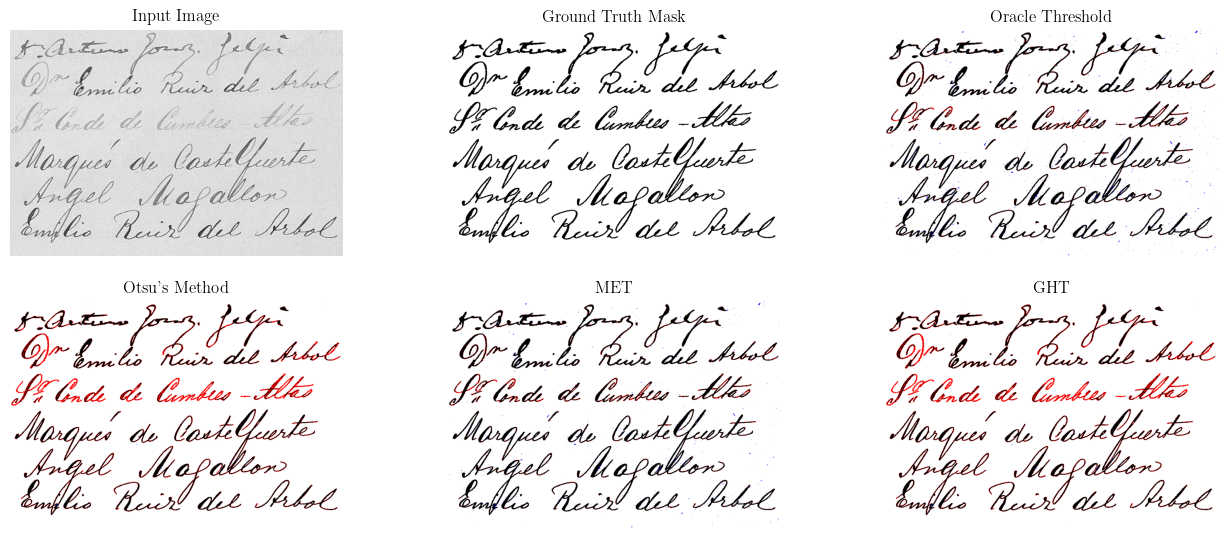

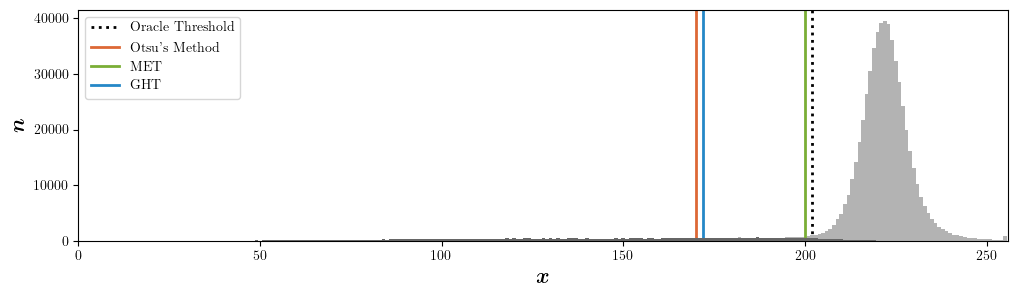

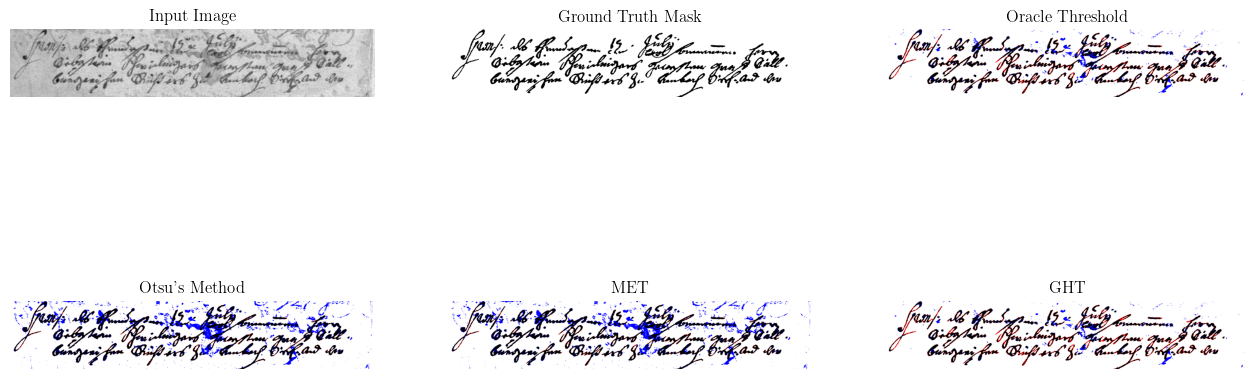

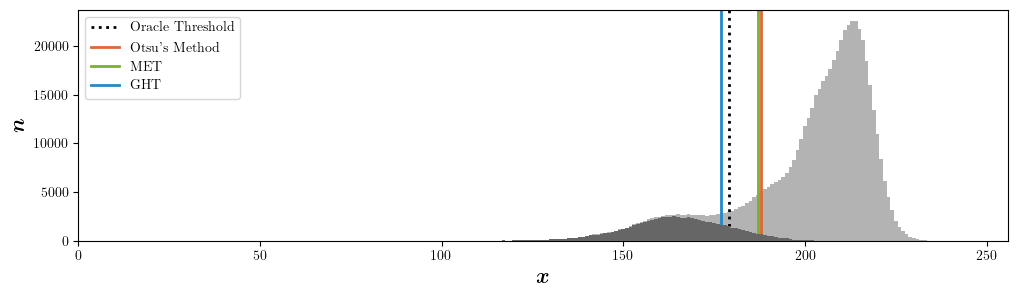

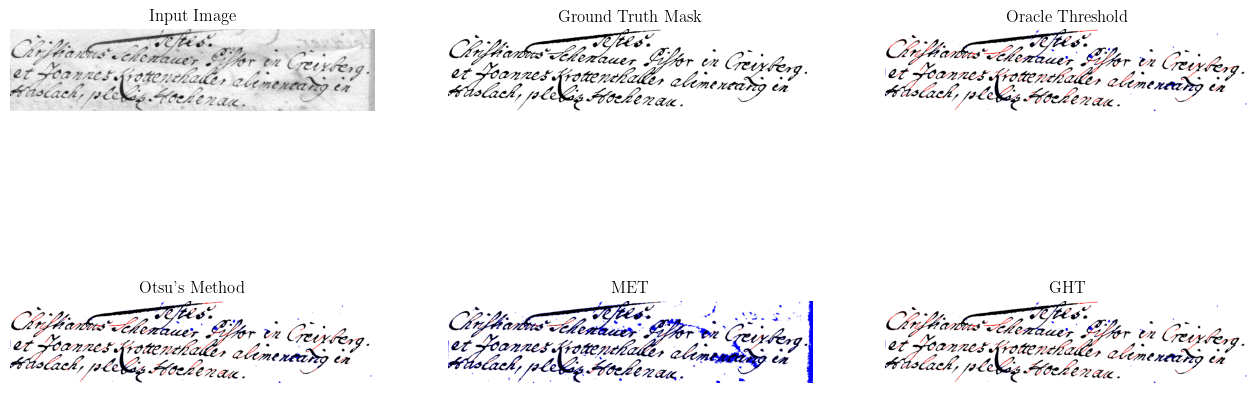

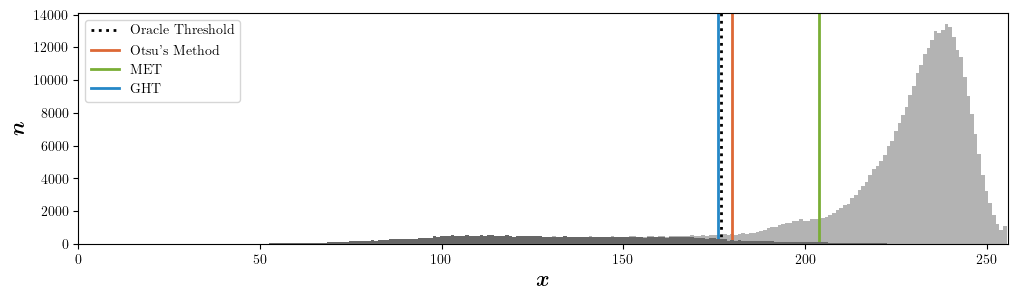

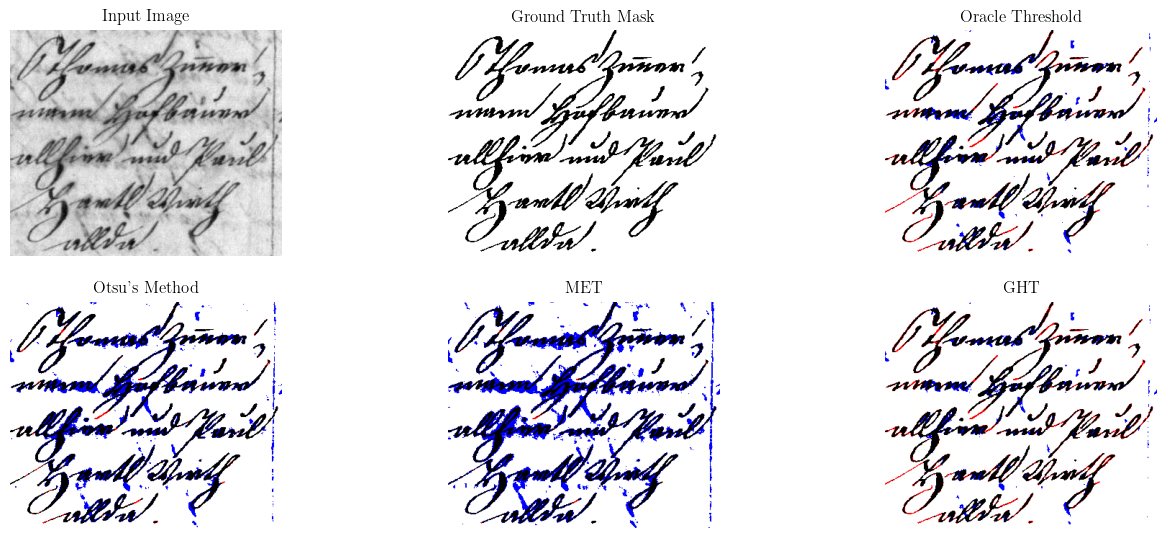

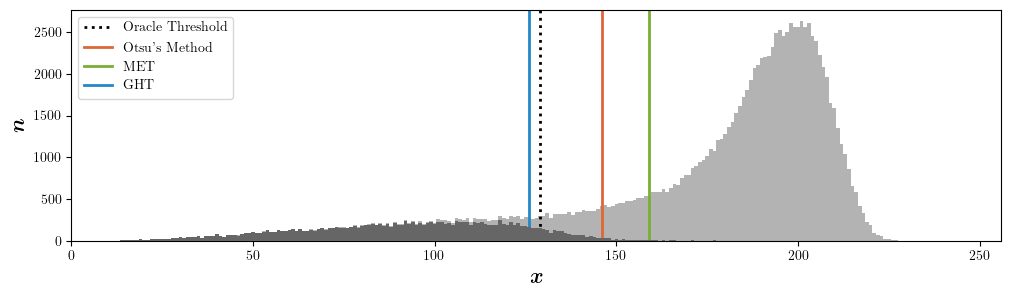

In [11]:
# Make all result figures.

all_names = [e[0][5:-1] for e in experiments[1:]]
all_names[0] = 'Otsu\'s Method'
all_names[1] = 'MET'
all_names[2] = r'wprctile ($\omega={0.0743}$)'
all_levels = experiment_results[1:]
all_names.insert(0, 'Oracle Threshold')
all_levels.insert(0, oracle_levels)

del all_names[3:5]
del all_levels[3:5]

for i_data in range(10):

  (im, x, n), gt = data[i_data]
  ts = [r[i_data] for r in all_levels]

  plt.figure(i_data*2, figsize=(16,10))

  plt.subplot(3, 3, 1)
  plt.imshow(im, cmap='gray')
  PIL.Image.fromarray(im).save(f'/tmp/results_{i_data}_im.png')
  plt.axis('off')
  plt.title('Input Image')

  plt.subplot(3, 3, 2)
  vis = 255*np.uint8(gt)
  PIL.Image.fromarray(vis).save(f'/tmp/results_{i_data}_gt.png')
  plt.imshow(vis, cmap='gray')
  plt.axis('off')
  plt.title('Ground Truth Mask');

  for i, (t, name) in enumerate(zip(ts, all_names)):
    plt.subplot(3, 3, i+3)
    vis = 255*np.uint8(np.stack([im > t, gt & (im > t), gt], -1))
    PIL.Image.fromarray(vis).save(f'/tmp/results_{i_data}_{name[:3]}_output.png')
    plt.imshow(vis)
    plt.axis('off')
    plt.title(name)

  n = np.histogram(im, np.arange(-0.5, 256))[0]
  n1 = np.histogram(im[~gt], np.arange(-0.5, 256))[0]
  top = np.max(n)*1.05

  plt.figure(i_data*2 + 1, figsize=(12,3))
  plt.bar(x, n, width=x[1] - x[0], color=[0.7, 0.7, 0.7], edgecolor=None, zorder=1)
  plt.bar(x, n1, width=x[1] - x[0], color=[0.4, 0.4, 0.4], edgecolor=None, zorder=3)
  plt.gca().set_xlim([0, 256])
  plt.gca().set_xlabel(r'$\boldsymbol{x}$', fontsize=15)
  plt.gca().set_ylabel(r'$\boldsymbol{n}$', fontsize=15)
  plt.gca().set_ylim([0, top])

  cols = [(0,0,0), colors[0], colors[2], colors[4]]

  for i, (t, name) in enumerate(zip(ts, all_names)):
    plt.plot([t,t], [0, top], label=name, color=cols[i], linewidth=2, zorder=2, linestyle='dotted' if i == 0 else None)
  plt.legend(loc='upper left')

  if SAVE_FIGURES:
    plt.savefig(f'/tmp/results_{i_data}_bar.png', dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches='tight', pad_inches=0.0,
            frameon=None, metadata=None)

<ipython-input-12-988e2e0e6ed4>:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(log_nus, shift + levels * np.ones_like(log_nus), marker_size, colors[6], label=r'$\operatorname{Otsu}$')
<ipython-input-12-988e2e0e6ed4>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(log_nus, [shift + level] * np.ones_like(log_nus), marker_size, colors[4], label=r'$\operatorname{MET}$')
<ipython-input-12-988e2e0e6ed4

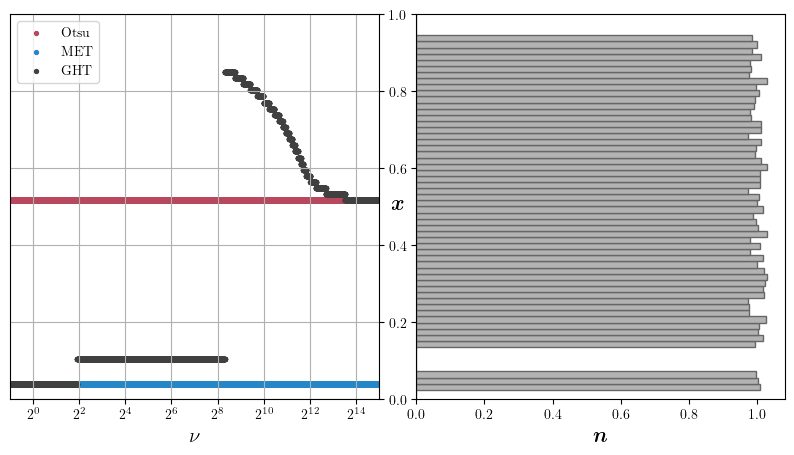

In [12]:
x = np.linspace(0, 1, 64)
n = np.zeros_like(x)
n[4:-9] = 1.
n[-5:-2] = 1
n = n[::-1]

np.random.seed(0)
n *= np.random.uniform(low=0.97, high=1.03, size=len(n))

tau = 0.01

plt.figure(-1, figsize=(10, 5))
plt.Axes(plt.gcf(), [0., 0., 1., 1.])
plt.subplots_adjust(wspace=0.1)
plt.subplot(1,2,1)

log_nus = np.linspace(-2, 16, 10000)
marker_size=8

shift = (x[1] - x[0]) / 2

levels = [GHT(n, x, nu=1e60, tau=1e-30)[0]]
plt.scatter(log_nus, shift + levels * np.ones_like(log_nus), marker_size, colors[6], label=r'$\operatorname{Otsu}$')

level, scores = GHT(n, x)
plt.scatter(log_nus, [shift + level] * np.ones_like(log_nus), marker_size, colors[4], label=r'$\operatorname{MET}$')

levels = []
for log_nu in log_nus:
  nu = 2**log_nu
  level, scores = GHT(n, x, nu=nu, tau=tau)
  levels.append(level)
plt.scatter(log_nus, shift + levels, marker_size, [0.25]*3, label=r'$\operatorname{GHT}$')

plt.xlim(-1, 15)
plt.ylim(0, 1.)
plt.gca().legend(loc='upper left')
plt.gca().set_xlabel(r'$\nu$', fontsize=15)
plt.grid(True)
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
z = plt.gca().set_ylabel(r'$\boldsymbol{x}$', fontsize=15)
z.set_rotation(0)
plt.gca().yaxis.set_label_coords(1.05, 0.53)
plt.yticks([0., 0.2, 0.4, 0.6, 0.8, 1.], ['']*6)
xtics = plt.xticks()[0][1:-1]
plt.xticks(xtics, ['$2^{{{:g}}}$'.format(x) for x in xtics])

plt.subplot(1,2,2)
plt.ylim(0, 1.)
plt.barh(x, n, height=x[1] - x[0], color=[0.7, 0.7, 0.7], edgecolor=[0.4, 0.4, 0.4])
plt.gca().set_xlabel(r'$\boldsymbol{n}$', fontsize=15)

if SAVE_FIGURES:
  plt.savefig('/tmp/nu_sweep.png', dpi=300, facecolor='w', edgecolor='w',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches='tight', pad_inches=0.0,
          frameon=None, metadata=None)

<ipython-input-13-bde349467458>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(omegas, shift + levels * np.ones_like(omegas), marker_size, colors[6], label=r'$\operatorname{Otsu}$')
<ipython-input-13-bde349467458>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(omegas, [shift + level] * np.ones_like(omegas), marker_size, colors[4], label=r'$\operatorname{MET}$')
<ipython-input-13-bde349467458>:36

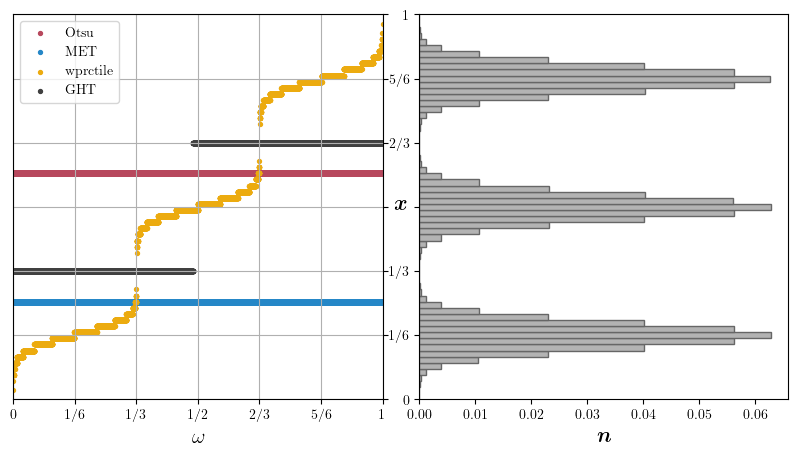

In [13]:
np.random.seed(3)

span = 0.2
count = 3
X = []
for i in range(count):
  mu = (i+0.5)/count
  scale = span/6
  X.append(mu + np.clip(np.random.normal(0, 1, 10000000), -4, 4) * scale)
X = np.concatenate(X)
n, hist_edge = np.histogram(X, np.linspace(0, 1, 64))
n = n / np.sum(n)
x = (hist_edge[1:] + hist_edge[:-1]) / 2

plt.figure(-1, figsize=(10, 5))
plt.Axes(plt.gcf(), [0., 0., 1., 1.])
plt.subplots_adjust(wspace=0.1)
plt.subplot(1,2,1)

shift = (x[1] - x[0]) / 2

omegas = np.linspace(1e-16, 1 - 1e-16, 10000)
marker_size=8

levels = [GHT(n, x, nu=1e60, tau=1e-30)[0]]
plt.scatter(omegas, shift + levels * np.ones_like(omegas), marker_size, colors[6], label=r'$\operatorname{Otsu}$')

level, scores = GHT(n, x)
plt.scatter(omegas, [shift + level] * np.ones_like(omegas), marker_size, colors[4], label=r'$\operatorname{MET}$')

tau = 0.01
kappa = 1e80
levels = []
for omega in omegas:
  levels.append(GHT(n, x, nu=nu, tau=tau, kappa=kappa, omega=omega)[0])
plt.scatter(omegas, shift + levels, marker_size, colors[1], label=r'$\operatorname{wprctile}$')

nu = 200
kappa = .1
tau = 0.01
levels = []
for omega in omegas:
  levels.append(GHT(n, x, nu=nu, tau=tau, kappa=kappa, omega=omega)[0])
plt.scatter(omegas, shift + levels, marker_size, [0.25]*3, label=r'$\operatorname{GHT}$')


plt.ylim(0, 1.)
plt.xlim(0, 1.)
plt.gca().legend()
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
z.set_rotation(0)
plt.gca().yaxis.set_label_coords(1.05, 0.53)
plt.gca().grid(True)
z = plt.gca().set_ylabel(r'$\boldsymbol{x}$', fontsize=15)
z.set_rotation(0)
plt.gca().yaxis.set_label_coords(1.05, 0.53)
plt.xticks(np.linspace(0, 1, 7), ['$0$', '$1/6$', '$1/3$', '$1/2$', '$2/3$', '$5/6$', '$1$'])
plt.yticks(np.linspace(0, 1, 7), [''] * 7)
plt.gca().set_xlabel(r'$\omega$', fontsize=15)

plt.subplot(1,2,2)
plt.barh(x, n, height=x[1] - x[0], color=[0.7, 0.7, 0.7], edgecolor=[0.4, 0.4, 0.4])
plt.ylim(0, 1.)
plt.yticks(np.linspace(0, 1, 7), ['$0$', '$1/6$', '$1/3$', ' ', '$2/3$', '$5/6$', '$1$'])
plt.gca().set_xlabel(r'$\boldsymbol{n}$', fontsize=15)

if SAVE_FIGURES:
  plt.savefig('/tmp/omega_sweep.png', dpi=300, facecolor='w', edgecolor='w',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches=None, pad_inches=0.0,
          frameon=None, metadata=None)